In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import funolympics_data_processing

In [2]:
df = pd.DataFrame()

def process_data(api_token, url):
        new_df = funolympics_data_processing.process_data(api_token, url)
        return pd.concat([df, new_df.loc[:np.random.choice(range(4500, 5000))]], ignore_index=True)

def filter_data(df):
    return df[df['Country'] != 'ZZ']

In [51]:
API_TOKEN = "fouNeeK3EUgh4Ap3gY7p9-E3iBiS0KMSQ84oWCu6ddo" # For Sandile_M
URL = "http://127.0.0.1:5000/api/olympicdata"

In [ ]:
# Load the data

for i in range(15):
    df = filter_data(process_data(API_TOKEN, URL))

In [53]:
df1 = df.copy()

In [54]:
print(df1.isnull().sum())

timestamp                0
IP                       0
request_method           0
resource                 0
status_code              0
response_size            0
user_agent               0
elapsed_time             0
Country                  0
Region                   0
City                     0
previous_timestamp    2357
session_duration         0
Device                   0
Operating_System         0
Browser                  0
Event                    0
Full Country Name        0
Continent                0
resource_group           0
sports_group             0
dtype: int64


In [55]:
# Count the unique IP addresses for each resource
df1['views'] = df1.groupby('resource')['resource'].transform('count')

In [56]:
df1.columns

Index(['timestamp', 'IP', 'request_method', 'resource', 'status_code',
       'response_size', 'user_agent', 'elapsed_time', 'Country', 'Region',
       'City', 'previous_timestamp', 'session_duration', 'Device',
       'Operating_System', 'Browser', 'Event', 'Full Country Name',
       'Continent', 'resource_group', 'sports_group', 'views'],
      dtype='object')

In [57]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['hour'] = df1['timestamp'].dt.hour
df1['day'] = df1['timestamp'].dt.day
df1['month'] = df1['timestamp'].dt.month
df1['year'] = df1['timestamp'].dt.year

# Encode categorical features
label_encoders = {}
categorical_columns = ['resource', 'status_code', 'Full Country Name', 'Region', 'City', 'Device', 'Operating_System', 'Browser', 'Event', 'resource_group', 'sports_group']
for col in categorical_columns:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le

# Drop unnecessary columns
df1 = df1.drop(columns=['timestamp', 'user_agent', 'previous_timestamp', 'Country', 'Continent', 'response_size', 'request_method', 'IP'])


In [58]:
# Separate numeric columns for correlation analysis
numeric_df = df1.select_dtypes(include=[np.number])

# Correlation analysis
corr = numeric_df.corr()
print(corr['views'].sort_values(ascending=False))

views                1.000000
sports_group         0.258768
resource_group       0.068066
session_duration     0.009993
Region               0.006892
Device               0.005626
Browser              0.001722
City                 0.001376
Full Country Name    0.000108
day                 -0.001266
Operating_System    -0.002818
hour                -0.002868
status_code         -0.003334
resource            -0.067233
Event               -0.147266
month                     NaN
year                      NaN
Name: views, dtype: float64


In [59]:
df1.shape

(249943, 18)

In [60]:
# Define features and target
X = df1.drop(columns=['views'])
y = df1['views']

# Models to evaluate
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Set up k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Output the scores
    print(f"{model_name} Cross-validation MSE scores:", -cv_scores)
    print(f"{model_name} Mean cross-validation MSE:", -np.mean(cv_scores))
    print(f"{model_name} Standard deviation of cross-validation MSE:", np.std(-cv_scores))

RandomForest Cross-validation MSE scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RandomForest Mean cross-validation MSE: -0.0
RandomForest Standard deviation of cross-validation MSE: 0.0
GradientBoosting Cross-validation MSE scores: [824.58424012 754.28688152 889.24757918 907.12387997 815.58733171
 797.71686496 806.76402885 773.49992626 785.34496647 782.30529556]
GradientBoosting Mean cross-validation MSE: 813.6460994597683
GradientBoosting Standard deviation of cross-validation MSE: 46.68685681199881
XGBoost Cross-validation MSE scores: [3.50984198e-07 2.67950242e-07 5.26953230e-07 3.35201603e-07
 5.03575066e-07 2.87296582e-07 4.34073675e-07 6.37846488e-07
 3.63923630e-07 2.16335719e-07]
XGBoost Mean cross-validation MSE: 3.9241404345158196e-07
XGBoost Standard deviation of cross-validation MSE: 1.2481028389775477e-07


In [61]:
# Define GradientBoostingRegressor model
gbr_model = GradientBoostingRegressor(random_state=42)

# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', gbr_model)
])

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(pipeline, param_dist, cv=3, n_iter=10, random_state=42, n_jobs=-1)

# Fit the model
rand_search.fit(X, y)

# Best model
best_model = rand_search.best_estimator_

# Best model performance
kf = KFold(n_splits=10, shuffle=True, random_state=42)
best_cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Output the best model's scores
print("Best model cross-validation MSE scores:", -best_cv_scores)
print("Best model mean cross-validation MSE:", -np.mean(best_cv_scores))
print("Best model standard deviation of cross-validation MSE:", np.std(-best_cv_scores))

Best model cross-validation MSE scores: [0.08667966 0.14928696 0.0979177  0.12260453 0.11782089 0.16933735
 0.09358886 0.11244439 0.09957146 0.14611824]
Best model mean cross-validation MSE: 0.11953700314217272
Best model standard deviation of cross-validation MSE: 0.02598708232748247


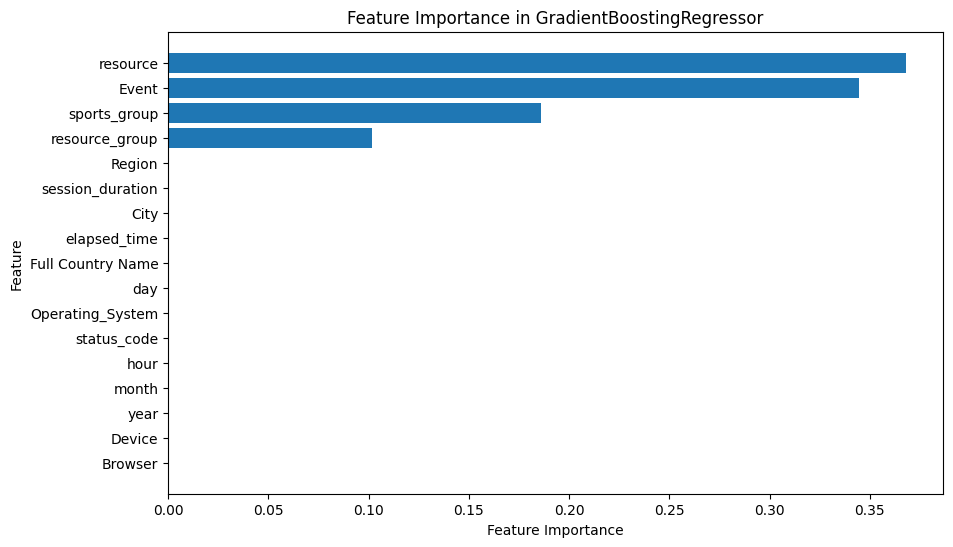

In [63]:
import matplotlib.pyplot as plt

# Extract the trained GradientBoostingRegressor from the pipeline
best_gbr = best_model.named_steps['regressor']

# Get feature importances
feature_importances = best_gbr.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in GradientBoostingRegressor')
plt.gca().invert_yaxis()
plt.show()

In [64]:
import joblib

# Save the best model and label encoders
joblib.dump(best_model, 'best_gradient_boosting_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']